#**Explorações Sonográficas e Acessibilidade de Dados:** A Percepção dos Brasileiros sobre o Trabalho por Aplicativos em Representações Inclusivas


## Introdução

Este caderno de código interativo hospedado no Google Colab é resultado de uma pesquisa conduzida ao longo de três meses para o programa de bolsas do Conecta Trabalhadores, projeto do Instituto de Tecnologia e Sociedade do Rio de Janeiro (ITS-Rio).

Aqui, exploro os dados da *survey* "Percepção dos Brasileiros sobre Trabalho por Aplicativo" a partir da computação e do som. Em uma primeira abordagem, pergunto o que ocorre ao traduzir os dados para uma representação sonora e não gráfica. Apresento a distribuição dos tipos de trabalhos associados ao trabalho de aplicativo em uma cacofonia agonizante; recomenda-se o uso de *headphones* e refletir sobre as sensações de se escutar o que se escuta, talvez ao também ler [o relatório de pesquisa original](https://itsrio.org/pt/publicacoes/pesquisa-nacional-sobre-a-percepcao-dos-brasileiros-sobre-o-trabalho-por-aplicativo-2024/). Em uma segunda abordagem, me desdobro sobre o problema da acessibilidade digital na pesquisa científica. Tomando as próprias representações visuais do relatório original como base, as reconstruo usando ferramentas multimodais, permitindo sua cognição em braille, texto e som.

O caderno é dividido em duas grandes seções que correspondem às referidas abordagens. Caso nunca tenha usado um caderno em formato .ipynb, é preferível que execute célula por célula de código (cada componente deste caderno é uma célula, podendo conter texto ou código) [1].

Espero que além de uma leitura agradável, este caderno permaneça para o acaso, como uma descoberta bem-aventurada e não-planejada (no sentido da palavra inglesa ‘serendipity’).

> “The biggest barrier for me is the time you need to spend tracking down formats you can access in order to gain the same information available to everybody else." Robin Williams, estatístico





## Justificativa e objetivos
1. Demonstrar a factabilidade de uma comunicação científica inclusiva _by design_, sem aumento de custos ou carga de trabalho, dois fatores limitantes para a implementação da acessibilidade.
2. Acessibilidade, ou melhor, sua ausência, é um problema significativo na academia ao ser um dos maiores fatores da redução da produtividade de pesquisadores com deficiências. Nesse sentido, ver [estudo de caso do repositório científico ArxiV](https://info.arxiv.org/about/accessibility_research_report.html).

3. * Fornecer um material passo-a-passo que possa ser útil como substrato para futuras incursões na comunicação científica em seus diferentes escopos.
   * O presente caderno CoLab é um dos componentes desse material.
   * Neste cenário, será feito um esforço para a escrita de comentários explicativos para que sua compreensão seja mais fecunda aos pesquisadores latinoamericanos sem uma educação formal em Ciências da Computação.





# Sonografias do trabalho de plataforma: sonificação dos dados da pesquisa IPEC/ITS

A sonificação, ou mapeamento sonoro, consiste na representação dos dados por meio de elementos sonoros ou, ainda, a comunicação através de áudio não-verbal. Esse conjunto de técnicas permite uma percepção auditiva das informações, oferecendo uma alternativa ou complemento às tradicionais visualizações gráficas. No contexto dos oceanos e do espaço sideral, a sonificação tem sido utilizada para representar correntes marítimas, mudanças climáticas e dados astronômicos, tornando acessíveis fenômenos que, de outra forma, seriam invisíveis aos nossos sentidos.

## Etapas para produzir uma sonografia experimental
Para aplicar a sonificação aos dados da pesquisa sobre a opinião de brasileiros acerca do trabalho de aplicativo, propomos o seguinte fluxo de trabalho:

1. **Seleção de Dados Relevantes**: Identificar quais aspectos da pesquisa serão sonificados.
2. **Definição de Parâmetros Sonoros**: Estabelecer como cada variável será representada sonoramente (por exemplo, alturas mais altas para maior frequência de uso).
3. **Desenvolvimento de Protótipos**: Utilizar softwares de sonificação para criar modelos iniciais e testar diferentes mapeamentos sonoros.

Nesse sentido, escolhi explorar a distribuição das respostas à pergunta abaixo, realizada na *survey*.

> Pergunta 1.4 De cada um dos tipos de trabalhos a seguir, por favor diga quais deles você associa diretamente ao trabalho por aplicativo?


## **Definindo o ambiente de trabalho**



*   Definir os módulos utilizados
*   Definir os caminhos de arquivo no Colab




In [ ]:
!pip install pydub
#a execução dessa primeira pode exigir ajustes. ao rodar localmente a partir de um arquivo .py, é mais adequado listar os módulos necessários (como pandas) em arquivo requirements.txt e executar pip install -r requirements.txt em um ambiente virtual

import sys
import pandas as pd
from pydub import AudioSegment, silence, effects
import os
import argparse
from multiprocessing import Pool, cpu_count




**Mapeando as variáveis aos caminhos dos seus arquivos (_filepaths_).**

Além da base de dados, é necessária uma lista de efeitos sonoros (todos copyleft, provenientes da freesound.org) utilizadas para a sintetização dos áudios**

In [ ]:
# Path para a base de dados; originalmente '230269_Percepção_Sobre_Trabalho_Por_Aplicativo_BD.xlsx', renomeado para data.xlsx
INPUT_FILE = 'data.xlsx'

# Path de dois áudios: um "teste" (parcial) e outro completo
OUTPUT_FILE_TEST = 'test_output.wav'
OUTPUT_FILE_FULL = 'full_output.wav'

# Mapa das colunas da BD com sons associáveis às atividades
COLUMN_SOUND_MAP = {
    'P1_4A': 'campanhia.wav',
    'P1_4B': 'buzina.wav',
    'P1_4C': 'vassoura.wav',
    'P1_4D': 'keyboard.wav',
    'P1_4E': 'giz.wav',
    'P1_4F': 'caminhao.wav',
    'P1_4G': 'ambulancia.wav',
}


## Primeiro mapeamento de variável. Grau de conhecimento como parâmetro de intervalo sonoro.

A ideia é relacionar os intervalos de áudio às respostas dos entrevistados. Definir o limite máximo de conjunto sonoro por resposta (1000ms, no caso) e por entrevistado (2500ms). Representar ausência de respostas como silêncio.

In [ ]:

# average P1_1 (grau de conhecimento) -> ms
INTERVAL_MAP = {
    1: 10,      # Simutâneo (overlap)
    2: 300,    # 0.25 entre sons
    3: 650,    # 0.5 seconds between sounds
    4: 1500,   # 1 second between sounds
}

# Valores máximos por row (som ou silêncio.)
MAX_ROW_DURATION = 2500.
SILENCE_DURATION = 1000.



**Aqui definimos uma função que cria um dicionário, estrutura simples de dados em Python.** Não seria nada eficiente conferir qual som corresponde a qual resposta para cada uma das potenciais 12000 queries (2000 respondentes e 6 subperguntas para a pergunta de interesse)**



*   `load_sounds (`função que utiliza variáveis definidas acima)
*   `apply_bpm_change` (modulação de batidas por minuto ao longo da track produzida)






In [ ]:
def load_sounds():
    """Carregar tipo de som em um dicionário"""
    sounds = {}
    for col, filename in COLUMN_SOUND_MAP.items():
        if os.path.exists(filename):
            sounds[col] = AudioSegment.from_wav(filename)
        else:
            # Silêncio place-holder para não-respostas
            sounds[col] = AudioSegment.silent(duration=1500)
    return sounds



In [ ]:
def apply_bpm_change(audio, start_ratio=0.15, final_bpm=140):
    """Alteração progressiva de BPM""" #JUSTIFICATIVA: trazer a temporalidade da distribuição; criar pelo ritmo do som, início e fim
    original_duration = len(audio)
    start_point = int(original_duration * start_ratio)
    initial_bpm = 30  # Começando em 60 bpm
    rate_change = final_bpm / initial_bpm

    # Gradação do aumento do ritmo a partir de 20% até 100% da track
    speed_changed = effects.speedup(audio[start_point:], playback_speed=rate_change, crossfade=50)
    combined_audio = audio[:start_point] + speed_changed
    return combined_audio


## Definindo mais parâmetros sonoros e sua correspondência com os dados

In [ ]:
from audioop import avg
def process_row(row, sounds):
    """Para cada linha (i.e. entrevistado), retornar e salva um segmento de áudio, função da biblioteca pydub; otimização do código"""
    # Definido pl_1_value a partir da coluna P1_1 - grau de conhecimento sobre trabalho de plataforma
    p_3_value = row.get('PL_3')
    if row.get('P1_1') not in INTERVAL_MAP:
    # Caso o valor esteja fora da escala 1-4 de P1_1; atribuir 3 (nada)
        row.get('P1_1')
    if p3_3_value not in INTERVAL_MAP:
        p3_3_value =0

    missingintervalo = average(row.get('P1_1'), p3_3_value)
    affirmative_sounds = []
    for col in COLUMN_SOUND_MAP.keys():
        value = row.get(col)
        if value == 1:
            affirmative_sounds.append(sounds[col])

    if not affirmative_sounds:
        # Em caso de um entrevista com apenas respostas negativas; produzir silêncio
        return AudioSegment.silent(duration=SILENCE_DURATION)

    # Sobrepondo sons de um conjunto de respostas de um entrevistas
    combined = affirmative_sounds[0]
    for sound in affirmative_sounds[1:]:
        combined = combined.overlay(sound)

    # Intervalo para evitar excesso de overlaps
    if missingintervalo > 0:
        combined_with_intervals = AudioSegment.silent(duration=200)
        for sound in affirmative_sounds:
            combined_with_intervals += sound + AudioSegment.silent(duration=interval)
        combined = combined.overlay(combined_with_intervals)

    # Max
    return combined[:MAX_ROW_DURATION]


**Função auxiliar utilizada com process_row para tornar o processamento mais célere**

In [ ]:
def process_rows_parallel(df, sounds):
    with Pool(cpu_count()) as pool:
        audio_segments = pool.starmap(process_row, [(row, sounds) for _, row in df.iterrows()])
    return sum(audio_segments, AudioSegment.empty())


In [ ]:

# Transformar áudio a partir das linhas do df
def export_audio(df, sounds, output_file, limit=None):
    """Generates audio from dataframe rows."""
    audio = AudioSegment.empty()
    for idx, row in df.iterrows():
        if limit and idx >= limit:
            break
        audio_segment = process_row(row, sounds)
        audio += audio_segment
    audio.export(output_file, format='wav')


In [ ]:


def main():
    #  Parser com argumentos

    parser = argparse.ArgumentParser(description="Processando áudio a partir do data set.")
    parser.add_argument('--input', type=str, required=True, help="Path para arquivo XLSX")
    parser.add_argument('--output_test', type=str, required=True, help="Path de WAV de teste")
    parser.add_argument('--output_full', type=str, required=True, help="Path de WAV completo")

# essa parte é importante para não dar dor-de-cabeça pedindo argumentos CLI em uma execução não-interativa =)

    try:
        args = parser.parse_args()
        input_file = args.input
        output_test = args.output_test
        output_full = args.output_full
    except SystemExit as e:
        print("Usando valores padrão")
        args = argparse.Namespace(input='data.xlsx', output_test='test_output.wav', output_full='full_output.wav')

    # preparando valores padrão
    input_file = args.input
    output_test = args.output_test
    output_full = args.output_full

    # Carregando arquivo xlsx
    df = pd.read_excel(input_file)

    # Carregando mapa de sons
    sounds = load_sounds()

    # Processar as primeiras 50 linhas para teste
    test_audio = process_rows_parallel(df.head(50), sounds)
    test_audio = apply_bpm_change(test_audio)
    test_audio.export(output_test, format='wav')

    # Processar todas as linhas para arquivo final; em grupos para agilizar (no caso, 25)
   # batch_size = 25  # Depende da capacidade da CPU e quantidade da RAM; dá pra aumentar ou diminuir (se não funcionar, alterar para "10"; remover comentários quando for usar)
   # full_audio = AudioSegment.empty()
   # for start_idx in range(0, len(df), batch_size):
   #     batch = df.iloc[start_idx:start_idx + batch_size]
   #     batch_audio = process_rows_parallel(batch, sounds)
   #     batch_audio = apply_bpm_change(batch_audio)
   #     full_audio += batch_audio

 # full_audio.export(output_full, format='wav')

if __name__ == '__main__':
    main()


## [Cacofonia P1.4, áudio produzido](https://soundcloud.com/waldo-ramalho/sets/sonificacao-das-atividades-associadas-ao-trabalho-de-aplicativo?si=bc4c0fb6ef9e4df3b43afdea9a712b1d&utm_source=clipboard&utm_medium=text&utm_campaign=social_sharing)

# Visualizações inclusivas das percepções dos brasileiros sobre o trabalho de aplicativo

Um dos principais problemas da efetivação da acessibilidade é o seu custo. Quando fluxos de trabalho, produtos ou materiais são elaborados sem incorporar as diferentes limitações e possibilidades do corpo e do espírito humano, alterá-los, muitas vezes, exigem recursos volumosos.

O que será explorado aqui é como reconstituir as visualizações dos dados do relatório original com o mínimo de custo para o desenvolvedor original, em qualquer momento do processo de elaboração da visualização. Para isso, utilizarei a linguagem Python e seu módulo maidr.



## MAIDR: Multimodal Access and Interactive Data Representation




*O maidr (pronunciado como "mader") é um sistema que permite o acesso e controle de gráficos estatísticos sem a necessidade de recursos visuais. Seu objetivo é proporcionar uma experiência inclusiva para usuários com deficiências visuais, oferecendo múltiplos modos de interação: braille, texto e sonificação (BTS). A sonificação é a conversão de dados em sons, permitindo que as informações sejam interpretadas auditivamente. Essa abordagem abrangente melhora a acessibilidade na visualização de dados e incentiva uma exploração multimodal—ou seja, através de diferentes sentidos—da visualização de informações.  
(tradução livre da descrição do repositório)* [W]

O maidr é um módulo escrito em JavaScript, mas com versões em Python e R. Sua operacionalização computacional é feita através das seguintes etapas:


1.   Escrita de código que produza um gráfico em formato SVG (*scalable vector graphics*), um tipo de formato para gráficos vetorizados.
2.   Geração de um arquivo HTML (*Hypertext Markup Language*). Esse arquivo é parte essencial da Web e, neste caso, seguirá o formato abaixo:


```
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="UTF-8" />
    <title>maidr Example</title>
    <link
      rel="stylesheet"
      href="https://cdn.jsdelivr.net/npm/maidr/dist/maidr_style.min.css"
    />
    <script src="https://cdn.jsdelivr.net/npm/maidr/dist/maidr.min.js"></script>
  </head>
  <body>
    <div>
      <!-- Your SVG plot is here -->
    </div>
  </body>
</html>
```


3. Caso o gráfico não tenha sido produzido com o auxílio do próprio Maidr, é necessário incluir os dados representados em formato JSON no próprio arquivo HTML. Por exemplo:



```
let maidr = {
  type: 'box',
  id: 'myboxplot',
  title: 'Highway Mileage by Car Class.',
  axes: {
    y: {
      label: 'Car Class',
      level: [
        '2seater',
        'compact',
        'midsize',
        'minivan',
        'pickup',
        'subcompact',
        'suv',
      ],
    },
    x: { label: 'Highway Milage' },
  },
  selector: '#boxplot1 g[id^="panel"] > g[id^="geom_boxplot.gTree"]',
  data: ...
}
```


**Navegação**

Teclas de seta: movem os pontos de dados no gráfico.

Ctrl+Seta Esquerda / Ctrl+Seta Direita (no Windows e Linux): reproduzem automaticamente os pontos de dados para a esquerda ou para a direita. Isso significa que o sistema percorre os pontos de dados nessa direção sem a necessidade de pressionar as teclas repetidamente.

Cmd+Seta Esquerda / Cmd+Seta Direita (no Mac): mesma função que acima, mas para computadores Mac.

PageUp / PageDown: alterna entre camadas (atualmente suportado apenas em gráficos de dispersão). Em gráficos complexos com múltiplas camadas de informações, essa função permite navegar entre elas.

B: ativa ou desativa o modo braille. Se você utiliza um dispositivo braille, essa tecla permite alternar sua funcionalidade.

T: alterna o anúncio de texto. Pressionar "T" cicla entre os modos "conciso", "detalhado" e "desligado", ajustando a quantidade de informação textual fornecida.

S: ativa ou desativa a sonificação (som espacial). A sonificação é a conversão de dados em sons, permitindo que você interprete as informações auditivamente.

H: abre o menu de Ajuda e configurações, onde é possível ajustar as preferências do sistema.

Ctrl+Shift+/ (no Windows e Linux): ativa ou desativa o chat com IA/LLM (Modelo de Linguagem de Aprendizado Profundo). Isso permite interagir com um assistente de inteligência artificial para obter ajuda adicional.

Opt+Shift+/ (no Mac): mesma função que acima, mas para computadores Mac.


Abaixo, uma tabela de atalhos adaptada do repositório.


| Função                           | Tecla (Windows)            | Tecla (Mac)                      |
|-----------------------------------|----------------------------|----------------------------------|
| Mover pelo gráfico                | Teclas de seta             | Teclas de seta                   |
| Ir para a borda (esquerda, direita, cima ou baixo) | Control + Tecla de seta   | Command + Tecla de seta          |
| Selecionar o primeiro elemento    | Control + Home             | Command + Function + Esquerda    |
| Selecionar o último elemento      | Control + End              | Control + Function + Direita     |
| Alternar Modo Braille             | B                          | B                                |
| Alternar Modo de Sonificação      | S                          | S                                |
| Alternar Modo de Texto            | T                          | T                                |
| Alternar Modo de Texto (opcional) | R                          | R                                |
| Repetir som atual                 | Espaço                     | Espaço                           |
| Reprodução automática para fora na direção da seta | Control + Shift + Tecla de seta | Command + Shift + Tecla de seta  |
| Reprodução automática para dentro na direção da seta | Alt + Shift + Tecla de seta | Option + Shift + Tecla de seta   |
| Parar Reprodução automática       | Control                    | Command                          |
| Acelerar Reprodução automática    | Ponto (.)                  | Ponto (.)                        |
| Desacelerar Reprodução automática | Vírgula (,)                | Vírgula (,)                      |



## Utilizando madr para prototipar o gráfico "Grau de conhecimento"

In [ ]:
%pip uninstall ipykernel -y -q -q -q
%pip install -U ipykernel -q -q -q
# Após, ambiente de execução -> reiniciar sessão, conforme sugerido nessa issue (https://github.com/mckinsey/vizro/issues/175)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is incompatible.


In [ ]:
!pip install -U maidr #git+https://github.com/xability/py_maidr.git

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import maidr
import IPython
import os
import pandas as pd
from google.colab import files

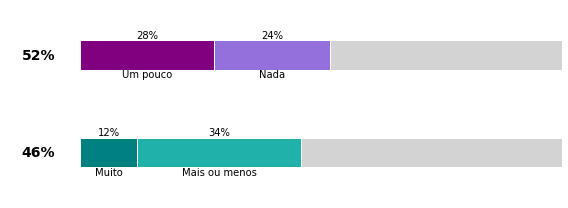

In [ ]:

from matplotlib.backends.backend_svg import FigureCanvasSVG

# Dados das barras
bars = [
    {
        'total_percentage': 46,
        'segments': [12, 34, 54],  # Percentages for each segment (sum to 100)
        'labels_above': ['12%', '34%', ''],
        'labels_below': ['Muito', 'Mais ou menos', ''],
        'colors': ['#008080', '#20B2AA', '#D3D3D3'],  # Teal tones and gray
        'ids': ['bar1_segment1', 'bar1_segment2', 'bar1_segment3']  # Unique IDs
    },
    {
        'total_percentage': 52,
        'segments': [28, 24, 48],
        'labels_above': ['28%', '24%', ''],
        'labels_below': ['Um pouco', 'Nada', ''],
        'colors': ['#800080', '#9370DB', '#D3D3D3'],  # Purple tones and gray
        'ids': ['bar2_segment1', 'bar2_segment2', 'bar2_segment3']  # Unique IDs
    }
]

fig, ax = plt.subplots(figsize=(8, 3))

# Loop de barras e segmentos pra SVG
for idx, bar in enumerate(bars):
    y_position = idx
    segments = bar['segments']
    left_positions = np.cumsum([0] + segments[:-1])
    colors = bar['colors']
    labels_above = bar['labels_above']
    labels_below = bar['labels_below']
    total_percentage = bar['total_percentage']
    segment_ids = bar['ids']

    # Segments
    for i in range(len(segments)):
        rects = ax.barh(
            y_position,
            segments[i],
            left=left_positions[i],
            color=colors[i],
            height=0.3,
            edgecolor='white'
        )
        # ID
        rects[0].set_gid(segment_ids[i])

    # Percentuais
    ax.text(-5, y_position, f"{total_percentage}%", fontsize=14, va='center', ha='right', fontweight='bold')


    for i in range(len(segments)-1):
        x_position = left_positions[i] + segments[i]/2
        ax.text(x_position, y_position + 0.15, labels_above[i], fontsize=10, ha='center', va='bottom')

    # Labels
    for i in range(len(segments)-1):
        x_position = left_positions[i] + segments[i]/2
        ax.text(x_position, y_position - 0.15, labels_below[i], fontsize=10, ha='center', va='top')


ax.axis('off')
ax.set_xlim(-15, 100)
ax.set_ylim(-0.5, len(bars) - 0.5)

plt.tight_layout()

# Salvar como SVG
canvas = FigureCanvasSVG(fig)
canvas.print_svg('stacked_barplot.svg')

plt.show()


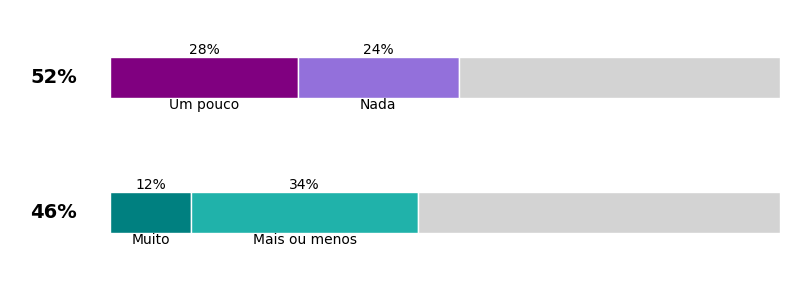

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import maidr

# Data for both bars
bars = [
    {
        'total_percentage': 46,
        'segments': [12, 34, 54],
        'labels_above': ['12%', '34%', ''],
        'labels_below': ['Muito', 'Mais ou menos', ''],
        'colors': ['#008080', '#20B2AA', '#D3D3D3'],
        'ids': ['bar1_segment1', 'bar1_segment2', 'bar1_segment3']
    },
    {
        'total_percentage': 52,
        'segments': [28, 24, 48],
        'labels_above': ['28%', '24%', ''],
        'labels_below': ['Um pouco', 'Nada', ''],
        'colors': ['#800080', '#9370DB', '#D3D3D3'],
        'ids': ['bar2_segment1', 'bar2_segment2', 'bar2_segment3']
    }
]

fig, ax = plt.subplots(figsize=(8, 3))

# Store all rectangles for maidr
rects_list = []

# Plot each bar
for idx, bar in enumerate(bars):
    y_position = idx  # Positions at y=0 and y=1
    segments = bar['segments']
    left_positions = np.cumsum([0] + segments[:-1])
    colors = bar['colors']
    labels_above = bar['labels_above']
    labels_below = bar['labels_below']
    total_percentage = bar['total_percentage']
    segment_ids = bar['ids']

    # Plot the segments
    for i in range(len(segments)):
        rects = ax.barh(
            y_position,
            segments[i],
            left=left_positions[i],
            color=colors[i],
            height=0.3,
            edgecolor='white',
            label=segment_ids[i]
        )
        rects[0].set_gid(segment_ids[i])  # Assign unique ID
        rects_list.append(rects[0])

    # Place total percentage on the left side
    ax.text(-5, y_position, f"{total_percentage}%", fontsize=14, va='center', ha='right', fontweight='bold')

    # Place percentage values above the segments
    for i in range(len(segments) - 1):  # Don't label the last gray segment
        x_position = left_positions[i] + segments[i] / 2
        ax.text(x_position, y_position + 0.15, labels_above[i], fontsize=10, ha='center', va='bottom')

    # Place description labels below the segments
    for i in range(len(segments) - 1):
        x_position = left_positions[i] + segments[i] / 2
        ax.text(x_position, y_position - 0.15, labels_below[i], fontsize=10, ha='center', va='top')

ax.axis('off')
ax.set_xlim(-15, 100)
ax.set_ylim(-0.5, len(bars) - 0.5)

plt.tight_layout()


# Create the maidr stacked bar object
stacked_maidr = maidr.stacked(ax)




In [ ]:
## confirmando tipagem e estrutura de dados
print(type(ax))
print(len(ax.patches))
dir(ax)


## Gerando o gráfico "Distribuição por classe" de forma automatizada



       Classe  Número de pessoas
0  Classe A/B                 23
1    Classe C                 50
2  Classe D/E                 27


'output/teste2.html'

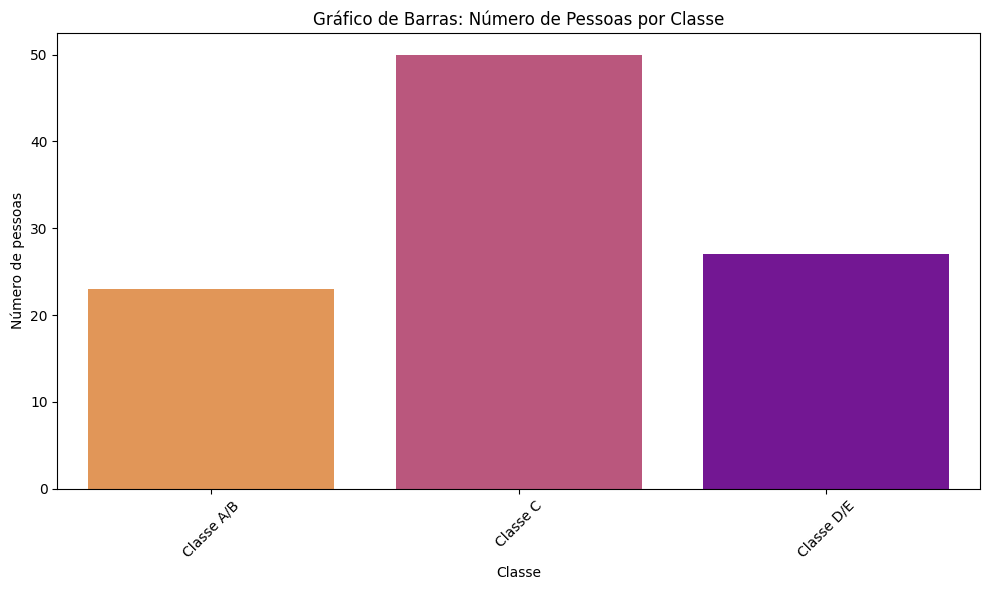

In [ ]:

# Ler o arquivo CSV
df = pd.read_csv('plotdata.csv')

# Exibir as primeiras linhas para entender a estrutura dos dados
print(df.head())

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))

b_plot = sns.barplot(
    x='Classe', y='Número de pessoas', data=df, palette='plasma_r'
)

# Adicionar rótulos e título
plt.xlabel('Classe')
plt.ylabel('Número de pessoas')
plt.title('Gráfico de Barras: Número de Pessoas por Classe')

# Rotacionar os rótulos do eixo x se estiverem sobrepostos
plt.xticks(rotation=45)

# Ajustar o layout para evitar cortes
plt.tight_layout()

# Exibir o gráfico
#plt.show(b_plot)
maidr.show(b_plot)
maidr.save_html(file="output/teste2.html", plot=b_plot)

## Gerando o gráfico "Tipos de serviço utilizados por aplicativos nos últimos 3 meses(%)", por região, idade e classe


In [ ]:
df = pd.read_csv('plotdata2.csv')

DataFrame structure:
             Category  Sim (%)
0               Total       69
1  Norte/Centro-Oeste       66
2            Nordeste       60
3                 Sul       73
4             Sudeste       77

Columns:
Index(['Category', 'Sim (%)'], dtype='object')


'output/teste3.html'

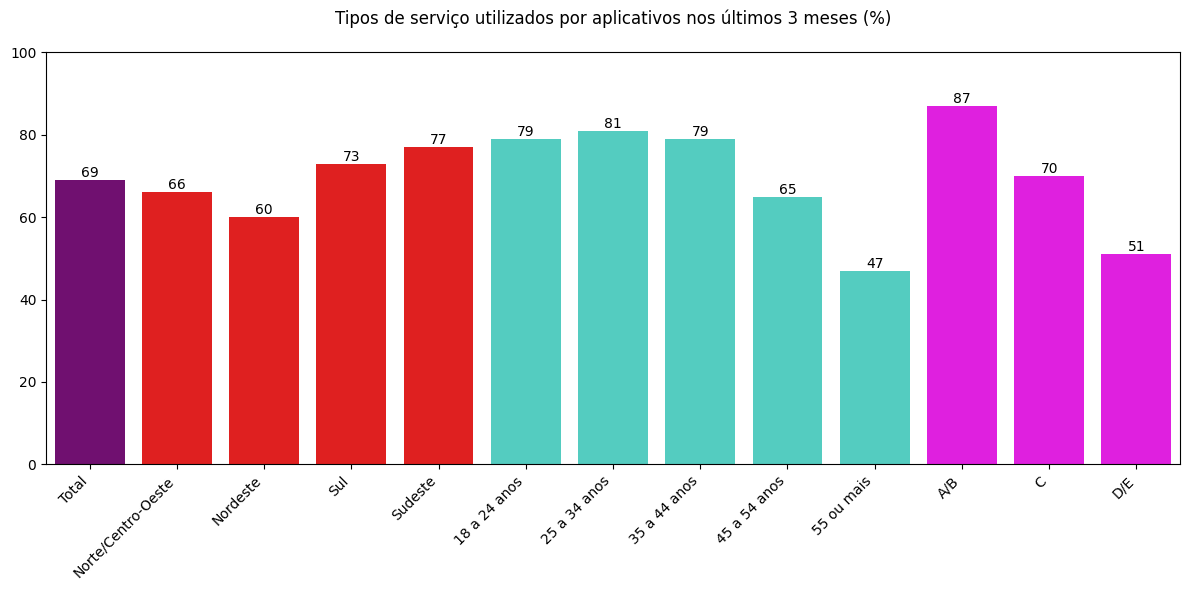

In [ ]:
# Print the dataframe to see its structure
print("DataFrame structure:")
print(df.head())
print("\nColumns:")
print(df.columns)


# Create the bar plot
plt.figure(figsize=(12, 6))

# Create bar plot using seaborn
b_plot = sns.barplot(
    data=df,
    x='Category',
    y='Sim (%)',
    palette=['purple', 'red', 'red', 'red', 'red',
             'turquoise', 'turquoise', 'turquoise', 'turquoise', 'turquoise',
             'magenta', 'magenta', 'magenta']
)

# Customize the plot
plt.title('Tipos de serviço utilizados por aplicativos nos últimos 3 meses (%)', pad=20)
plt.xlabel('')
plt.ylabel('')

# Add value labels on top of each bar
for i, v in enumerate(df['Sim (%)']):
    b_plot.text(i, v, str(v), ha='center', va='bottom')

# Set y-axis limits
plt.ylim(0, 100)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

maidr.show(b_plot)
maidr.save_html(file="output/teste3.html", plot=b_plot)

## Gerando o gráfico "O quanto os brasileiros concordam com as seguintes frases sobre trabalho por aplicativo?

ExtractionError: Error extracting data for bar plot type from <class 'list'>.

<Figure size 1800x1200 with 0 Axes>

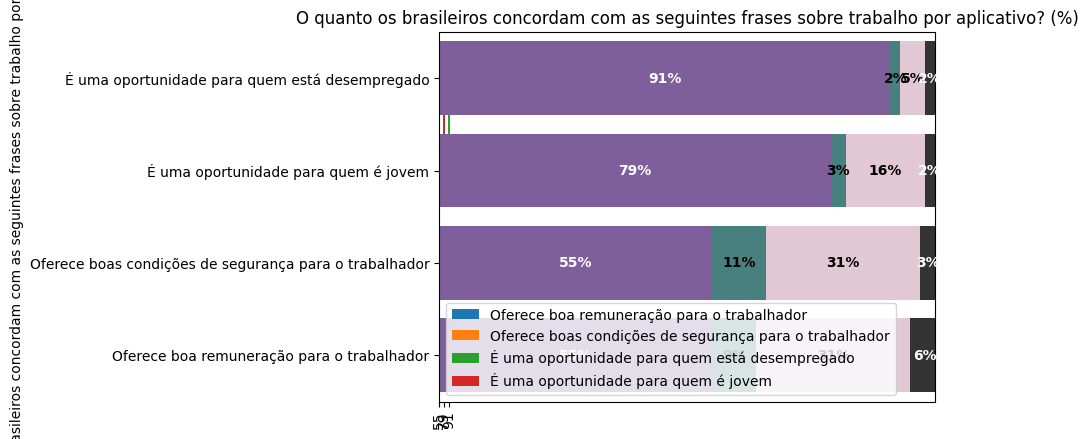

In [ ]:

# Read the CSV file
df = pd.read_csv('plotdata3.csv')

# Create the plot
plt.figure(figsize=(18, 12))

grouped = df.groupby(["Concorda totalmente/ concorda em parte", "O quanto os brasileiros concordam com as seguintes frases sobre trabalho por aplicativo? (%)"]).size().unstack()

    # Plotting the stacked bar chart
stacked = grouped.plot(kind="bar", stacked=True)
# Create horizontal bar plot
b_plot = sns.barplot(
    x=df['Concorda totalmente/ concorda em parte'],
    y=df['O quanto os brasileiros concordam com as seguintes frases sobre trabalho por aplicativo? (%)'] ,  # Using index for the statements
    data=df,
    color='#7E55A5',  # Purple color similar to the image
    orient='h'
)

# Add the other bars
sns.barplot(
    x=df['Não concorda nem discorda'],
   y=df['O quanto os brasileiros concordam com as seguintes frases sobre trabalho por aplicativo? (%)'] ,
    color='#3D8A88',
    orient='h',
      data=df,
    left=df['Concorda totalmente/ concorda em parte']

)

sns.barplot(
    x=df['Discorda em parte/ Discorda totalemnte'],
   y=df['O quanto os brasileiros concordam com as seguintes frases sobre trabalho por aplicativo? (%)'] ,
    color='#E5C4D3',
    orient='h',
      data=df,
    left=df['Concorda totalmente/ concorda em parte'] + df['Não concorda nem discorda']
)

sns.barplot(
    x=df['NS/NR'],
   y=df['O quanto os brasileiros concordam com as seguintes frases sobre trabalho por aplicativo? (%)'] ,
    color='#333333',
    orient='h',
      data=df,
    left=df['Concorda totalmente/ concorda em parte'] + df['Não concorda nem discorda'] + df['Discorda em parte/ Discorda totalemnte']
)

# Add annotations to display values inside each segment
for i in range(len(df)):
    # Concorda totalmente/ concorda em parte
    plt.text(
        df['Concorda totalmente/ concorda em parte'][i] / 2,  # x position (center of the first bar)
        i,  # y position
        f"{df['Concorda totalmente/ concorda em parte'][i]:.0f}%",  # value text
        ha='center', va='center', color='white', fontweight='bold'
    )

    # Não concorda nem discorda
    plt.text(
        df['Concorda totalmente/ concorda em parte'][i] + df['Não concorda nem discorda'][i] / 2,  # center of the second bar
        i,
        f"{df['Não concorda nem discorda'][i]:.0f}%",
        ha='center', va='center', color='black', fontweight='bold'
    )

    # Discorda em parte/ Discorda totalemnte
    plt.text(
        df['Concorda totalmente/ concorda em parte'][i] + df['Não concorda nem discorda'][i] + df['Discorda em parte/ Discorda totalemnte'][i] / 2,  # center of the third bar
        i,
        f"{df['Discorda em parte/ Discorda totalemnte'][i]:.0f}%",
        ha='center', va='center', color='black', fontweight='bold'
    )

    # NS/NR
    plt.text(
        df['Concorda totalmente/ concorda em parte'][i] + df['Não concorda nem discorda'][i] + df['Discorda em parte/ Discorda totalemnte'][i] + df['NS/NR'][i] / 2,  # center of the fourth bar
        i,
        f"{df['NS/NR'][i]:.0f}%",
        ha='center', va='center', color='white', fontweight='bold'
    )


# Customize the plot
plt.title('O quanto os brasileiros concordam com as seguintes frases sobre trabalho por aplicativo? (%)')
plt.xlabel('')
plt.xlim(0, 100)


# Add legend
#legend_labels = ['Concorda totalmente/ concorda em parte',
#                'Não concorda nem discorda',
#                'Discorda em parte/ Discorda totalemnte',
#                'NS/NR']
#plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
#plt.tight_layout()
maidr.show(b_plot)
maidr.save_html(file="output/teste4.html", plot=b_plot)


## É possível reproduzir a própria planilha?

Embora parece ser um problema menor, infelizmente o maidr não é utilizável para transformar tabelas ou planilhas para formato HTML. No entanto, para tabelas simples, é algo relativamente simples com software livre, como fiz abaixo.



In [ ]:
!git clone -b python https://github.com/dbohdan/csv2html
%cd csv2html
!python setup.py install --user

In [ ]:
!csv2html -o testeee.html test/test.csv

# Conclusão

A sonificação dos dados acerca da percepção dos brasileiros sobre trabalho de aplicativo (e bases de dados similares) apresenta várias possibilidades criativas, de sensibilização com o que está se afirmando com uma representação. É uma experiência corporificada de um dado. Ao contrário da máxima "tradutor, traidor", mapear os dados à parâmetros sonoros é uma tradução fecunda, não buscando substituir a visualização de dados tradicional.

A acessibilidade dos dados através do som e da computação permanece um grande desafio. O MAIDR é representante do estado da arte e, ainda assim, possui grandes limitações, além de ainda não ter uma adoção universal. Mas utilizá-lo para tornar acessível as visualizações do relatório aponta que suas escolhas por multimodalidade, autonomia do usuário e implementação de baixo custo foram acertadas.

MAIDR também é um projeto de *software* livre. Para um iniciante, um bom ponto de partida para contribuir com o projeto seria localizá-lo em português. Uma contribuição mais avançada, mas com sérias implicações, seria trabalhar na sugestão de torná-lo uma das opções de *backend* do `matplotlib`, o módulo de facto da estatística em Python.

# Notas de fim

# Referências

**Artigos**

BRINN, Shamsi; CAMERON, Christopher; FIELDING, David; et al. A framework for improving the accessibility of research papers on arXiv.org. 2024. Disponível em: <http://arxiv.org/abs/2212.07286>. Acesso em: 19 out. 2024.

CIUCCARELLI, Paolo; LENZI, Sara. Intentionality and design in the data sonification of social issues. Big Data & Society, v. 7, n. 2. 2020. Disponível em: <https://journals.sagepub.com/doi/epub/10.1177/2053951720944603>. Acesso em: 9 set. 2024.

DUBUS, Gaël; BRESIN, Roberto. A systematic review of mapping strategies for the sonification of physical quantities. PLOS ONE, v. 8, n. 12, p. 82491, 2013.

ENGE, Kajetan; RIND, Alexander; IBER, Michael; et al. Towards a unified terminology for sonification and visualization. Personal and Ubiquitous Computing, v. 27, n. 5, p. 1949–1963, 2023.

FAN, Danyang; FAY SIU, Alexa; RAO, Hrishikesh; et al. The Accessibility of Data Visualizations on the Web for Screen Reader Users: Practices and Experiences During COVID-19. ACM Trans. Access. Comput., v. 16, n. 1, p. 4:1-4:29, 2023.

NEUHOFF, John G. Is Sonification Doomed to Fail? In: Proceedings of the 25th International Conference on Auditory Display (ICAD 2019). Newcastle upon Tyne: Department of Computer and Information Sciences, Northumbria University, 2019, p. 327–330. Disponível em: <http://hdl.handle.net/1853/61531>. Acesso em: 9 set. 2024.

SEO, JooYoung; XIA, Yilin; LEE, Bongshin; et al. MAIDR: Making Statistical Visualizations Accessible with Multimodal Data Representation. In: Proceedings of the 2024 CHI Conference on Human Factors in Computing Systems. New York, NY, USA: Association for Computing Machinery, 2024, p. 1–22. (CHI ’24). Disponível em: <https://dl.acm.org/doi/10.1145/3613904.3642730>. Acesso em: 23 out. 2024.


**Portfólios de creative coders, artistas e coletivos**

Aaron Koblin. Disponível em: <https://www.aaronkoblin.com/>

Luke Dubois. Disponível em: <https://www.lukedubois.com/>

Robert Hodgkin. Disponível em: <https://roberthodgin.com/>

Studio Nand. Disponível em: <https://www.nand.io/case-studies>

We feel fine (Jonathan Harris and Sep Kamvar). Disponível em: <http://wefeelfine.org/>


**Visualização de dados**

FRAGAPANE, Federica. Federica Fragapane profile. Behance. Disponível em: <https://www.behance.net/FedericaFragapane>. Acesso em: ago/set. 2024.

FRAGAPANE, Federica; PIACENTINI, Alex. The stories behind a line. Disponível em: <http://www.storiesbehindaline.com/>. Acesso em: ago/set. 2024.

FRAGAPANE, Federica. Graphics for the Publications Office of the EU. Behance. Disponível em: <https://www.behance.net/gallery/188704943/Graphics-for-the-Publications-Office-of-the-EU?tracking_source=search_projects_appreciations|data+visualization&l=1>. Acesso em: ago/set. 2024.

Flowing Data. Disponível em: <https://flowingdata.com/>. Acesso em: ago/set. 2024.

GRINIŪTĖ, Greta; KORSAKAITE, Kamile; PAUKSTE, Augustinas; et al. Digital Culture Index. Behance. Disponível em: <https://www.behance.net/gallery/202754337/Digital-Culture-Index?tracking_source=search_projects_appreciations|data+visualization&l=0>. Acesso em: ago/set. 2024.

LUPI, Giorgia. Dear Data. Behance. Disponível em: <https://www.behance.net/gallery/40819275/Dear-Data?tracking_source=search_projects_appreciations|data+visualization l=1>. Acesso em: ago/set. 2024.

MARIMUTHU, Prasanth; ROY, Suvo; SAHAY, Shashank; et al. A Guide to Data Visualization. Behance. Disponível em: <https://www.behance.net/gallery/60621729/A-Guide-to-Data-Visualization-Comparison-Part-1?tracking_source=search_projects_appreciations|data+visualization&l=7>. Acesso em: ago/set. 2024.

Our World in Data: Research and data to make progress against the world’s largest problems. Disponível em: <https://ourworldindata.org/>. Acesso em: ago/set. 2024.

STEFANER, Moritz. The Rhythm of Food: Analyzing food seasonality.  Truth and beauty. Disponível em: <https://truth-and-beauty.net/projects/the-rhythm-of-food>. Acesso em: ago/set. 2024.

STEFANER, Moritz. OECD Better Life Index. How's life?  Truth and beauty. Disponível em: <https://truth-and-beauty.net/projects/oecd-better-life-index>. Acesso em: ago/set. 2024.

STEFANER, Moritz. Emoto: Visualizing the online response to London 2012.  Archive Stefaner. Disponível em: <http://archive.stefaner.eu/projects/emoto/>. Acesso em: ago/set. 2024.

VIDEIRA, Luísa. Data visualization.  Behance. Disponível em: <https://www.behance.net/gallery/185742751/data-visualization?tracking_source=search_projects_comments|data+visualization&l=1>. Acesso em: ago/set. 2024.



**Multimodalidade e representação de dados**


JONES, Austin. Dali-rs.  GitHub. Disponível em: <https://github.com/austinjones/dali-rs>. Acesso em: ago/set. 2024.

KUHN, Josh. Making Generative Art with Rust.  Abor. Disponível em: <https://blog.abor.dev/p/making-generative-art-with-rust?r=jx6d6>. Acesso em: ago/set. 2024.

MetaLAB (at) Harvard.  Harvard. Disponível em: <https://cyber.harvard.edu/research/metalab>. Acesso em: ago/set. 2024.

Orbit.  Patreon. Disponível em: <https://www.patreon.com/posts/nascent-art-for-39070865>. Acesso em: ago/set. 2024.

Rerun.  GitHub. Disponível em: <https://github.com/rerun-io/rerun>. Acesso em: ago/set. 2024.

SIU, Matthew W.  Personal site eight pied. Disponível em: <https://personal-site-eight-pied.vercel.app>. Acesso em: ago/set. 2024.

STAHL, Peter M. Grex.  GitHub. Disponível em: <https://github.com/pemistahl/grex>. Acesso em: ago/set. 2024.

Repositórios de projetos relacionados à visualização de dados, sonificação e/ou acessibilidade digital Crate csv-rust.  Docs.rs. Disponível em: <https://docs.rs/csv/latest/csv/>. Acesso em: ago/set. 2024.

Fyrox.  GitHub. Disponível em: <https://github.com/FyroxEngine/Fyrox>. Acesso em: ago/set. 2024.

GALLANT, Andrew. Rust-cvs.  GitHub. Disponível em: <https://github.com/BurntSushi/rust-csv>. Acesso em: ago/set. 2024.

HASHEMI, Shayan. Tabiew.  GitHub. Disponível em: <https://github.com/shshemi/tabiew>. Acesso em: ago/set. 2024.

Lava-xyz. Rust-Ontologist.  GitHub. Disponível em: <https://github.com/lava-xyz/rust-ontologist>. Acesso em: ago/set. 2024.

Nannou.  GitHub. Disponível em: <https://github.com/nannou-org/nannou>. Acesso em: ago/set. 2024.

Musnix.  GitHub. Disponível em: <https://github.com/musnix/musnix>. Acesso em: ago/set. 2024.

Ratatui.  GitHub. Disponível em: <https://github.com/ratatui/ratatui>. Acesso em: ago/set. 2024.

Super Collider.  GitHub. Disponível em: <https://github.com/supercollider/supercollider>. Acesso em: ago/set. 2024.

Urpflanze Org. Core.  GitHub. Disponível em: <https://github.com/urpflanze-org/core>. Acesso em: ago/set. 2024.

Valora.  Crates.io. Disponível em: <https://crates.io/crates/valora>. Acesso em: ago/set. 2024.

VARIER, Chai. Lorenz Sonified.  GitHub. Disponível em: <https://github.com/cvarier/Lorenz-Sonified>. Acesso em: ago/set. 2024.

WasmEdge Runtime. Media Pipe.  GitHub. Disponível em: <https://github.com/WasmEdge/mediapipe-rs>. Acesso em: ago/set. 2024.

